In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, classification_report, confusion_matrix

In [3]:
train_data = pd.read_csv('../data/processed_train.csv')
test_data = pd.read_csv('../data/processed_test.csv')

In [4]:
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].fillna('')
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].fillna('')

In [5]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_data['crimeaditionalinfo'])
X_test = vectorizer.transform(test_data['crimeaditionalinfo'])

In [19]:
label_encoder = LabelEncoder()

all_categories = pd.concat([train_data['category'], test_data['category']]).unique()
label_encoder.fit(all_categories)

y_train_category = label_encoder.transform(train_data['category'])
y_test_category = label_encoder.transform(test_data['category'])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Encoded labels (y_train): {y_train_category}")
print(f"Encoded labels (y_test): {y_test_category}")

Shape of X_train: (91186, 5000)
Shape of X_test: (22797, 5000)
Encoded labels (y_train): [7 9 9 ... 9 9 9]
Encoded labels (y_test): [ 0  9 14 ...  9  9  9]


In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train_category)
y_pred_category = model.predict(X_test)

In [21]:
accuracy = accuracy_score(y_test_category, y_pred_category)
print(f"Accuracy Score: {accuracy}")
print("Category Classification Report:\n", classification_report(y_test_category, y_pred_category))

Accuracy Score: 0.7362372241961661
Category Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.09      0.16      2891
           1       0.81      0.18      0.30        94
           2       0.00      0.00      0.00         1
           3       0.88      0.11      0.20       126
           4       1.00      1.00      1.00       974
           5       0.00      0.00      0.00        42
           6       0.71      0.08      0.14       460
           7       0.57      0.57      0.57      3235
           8       0.00      0.00      0.00        49
           9       0.76      0.98      0.85     13861
          10       0.00      0.00      0.00       116
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        65
          13       0.40      0.01      0.01       395
          14       0.50      0.03      0.06       473

    accuracy                           0.74     22797
   macro avg

/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

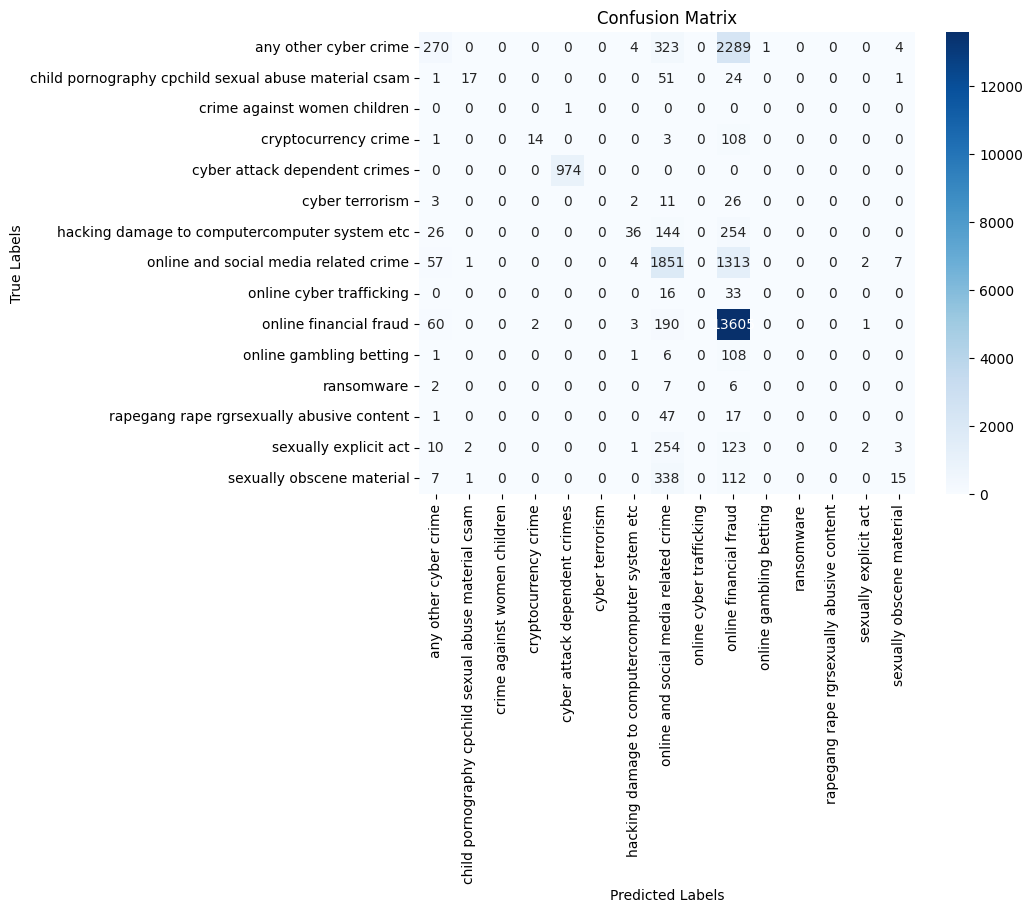

In [22]:
cm = confusion_matrix(y_test_category, y_pred_category)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
label_encoder = LabelEncoder()

all_sub_categories = pd.concat([train_data['sub_category'], test_data['sub_category']]).unique()
label_encoder.fit(all_sub_categories)

y_train_sub_category = label_encoder.transform(train_data['sub_category'])
y_test_sub_category = label_encoder.transform(test_data['sub_category'])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Encoded labels (y_train): {y_train_sub_category}")
print(f"Encoded labels (y_test): {y_test_sub_category}")

Shape of X_train: (91186, 5000)
Shape of X_test: (22797, 5000)
Encoded labels (y_train): [15 19 19 ... 16 19 35]
Encoded labels (y_test): [26 35 37 ... 35 35 35]


In [24]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train_sub_category)
y_pred_sub_category = model.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test_sub_category, y_pred_sub_category)
print(f"Accuracy Score: {accuracy}")
print("Sub-Category Classification Report:\n", classification_report(y_test_sub_category, y_pred_sub_category))

Accuracy Score: 0.5223494319427995
Sub-Category Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.40      0.01      0.02       531
           2       0.00      0.00      0.00         1
           3       0.81      0.17      0.29       126
           5       0.48      0.56      0.52      1081
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        33
           8       0.15      0.17      0.16       128
           9       0.68      0.75      0.71      2693
          10       0.25      0.01      0.02       200
          11       0.18      0.17      0.18       146
          12       0.55      0.13      0.21        95
          13       0.00      0.00      0.00        42
          14       0.69      0.32      0.44      1081
          15       0.50      0.35      0.41       618
          16       0.33      0.11      0.16      1511
         

/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

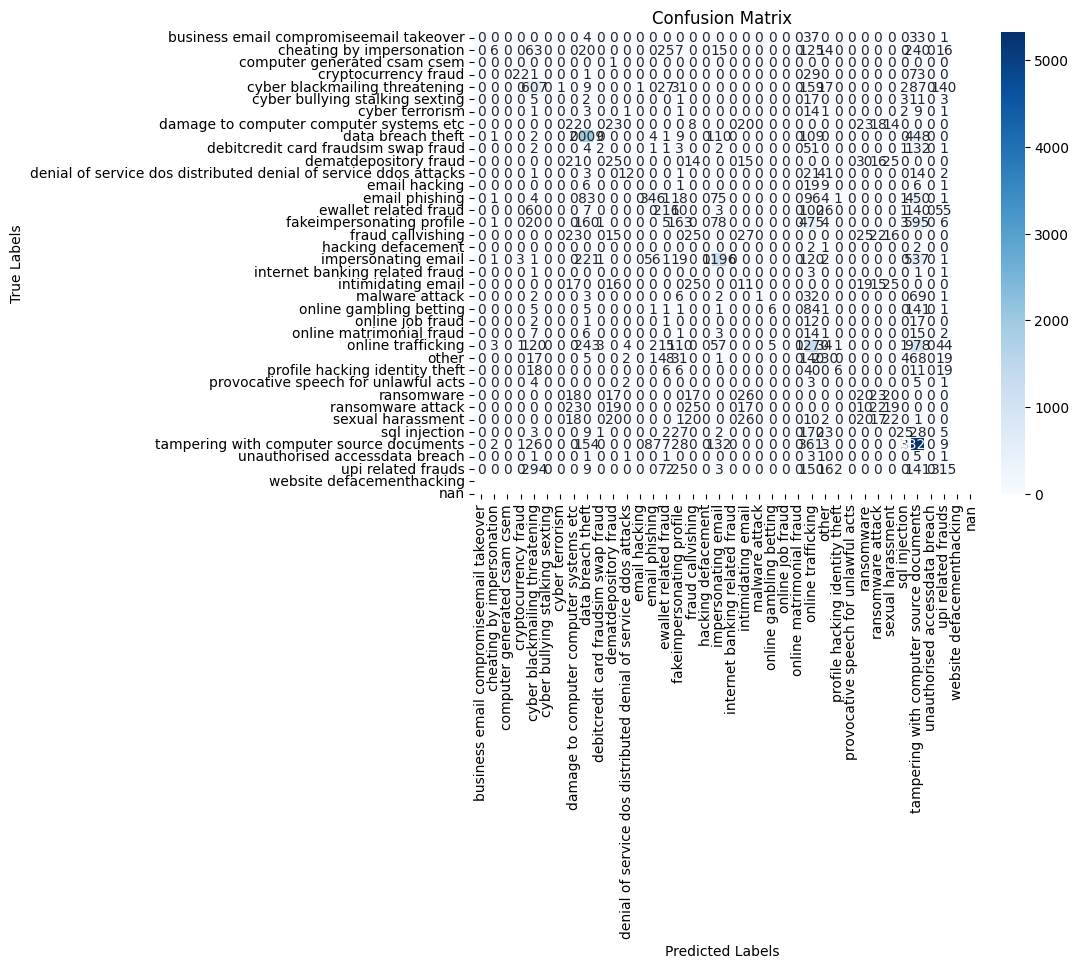

In [25]:
cm = confusion_matrix(y_test_sub_category, y_pred_sub_category)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [26]:
joint_correct = (y_test_category == y_pred_category) & (y_test_sub_category == y_pred_sub_category)
joint_accuracy = joint_correct.mean()

print("Joint Accuracy:", joint_accuracy)

Joint Accuracy: 0.46238540158792824
